In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_palette('colorblind')
from matplotlib.pyplot import tight_layout
# ##SETTING PARAMS FOR MATPLOTLIB FIGURES
plt.rcParams.update({"figure.figsize": (6, 6),
                 "axes.facecolor": "white",
                 "axes.edgecolor": "black"})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('colorblind'))
##set font size
font = {'family': 'sans-serif',
       'weight': 'normal',
       'size': 14}
plt.rc('font', **font)
# ##PANDAS PLOTTING
pd.plotting.register_matplotlib_converters()

### Step 1: save environment file

In [2]:
!conda env export > quasi_poisson_environment.yml

### Step 2: import modules

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import re
import patsy

# Function to parse model summary text and extract coefficients

# For inline plots in Jupyter
%matplotlib inline
import pandas as pd
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
import openpyxl

### Step 3 : Import files

In [4]:
data_directory_weather = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2014-2023_cleaned_v4.csv"
data_directory_nas = "/home/paulharford/college/project/project_data/nas/WEATHERED_nas_clean_v1.csv"
data_directory_census = "/home/paulharford/college/project/project_data/processed/WEATHERED_census_pop_age_grp_gender_region.csv"
full_path_nas = os.path.abspath(data_directory_nas)
full_path_weather = os.path.abspath(data_directory_weather)
full_path_census = os.path.abspath(data_directory_census)

In [5]:
df_nas = pd.read_csv(full_path_nas)
df_weather = pd.read_csv(full_path_weather)
df_census = pd.read_csv(full_path_census)

In [6]:
df_weather["Valid From"] = pd.to_datetime(df_weather["Valid From"])
df_weather["date"] = df_weather["Valid From"].dt.date
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["Valid To"] = pd.to_datetime(df_weather["Valid To"])


### Step 3: Create full dates range for 2014 to 2023 to merge with datasets 

In [7]:
##add full date calandar to the aggregation 
# 1a. Identify all unique regions
regions = df_weather['region'].unique()

# 1b. Identify the full date range
min_date = df_weather['date'].min()
max_date = df_weather['date'].max()

In [8]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [9]:
##copy full date range for hip and weather data
df_region_date_nas = df_region_date.copy()

In [10]:
df_region_date_weather = df_region_date.copy()

In [11]:
df_region_date_census = df_region_date.copy()

In [12]:
df_region_date.head()

,region,date
0,HSE Dublin and Midlands,2014-01-02
1,HSE Dublin and Midlands,2014-01-03
2,HSE Dublin and Midlands,2014-01-04
3,HSE Dublin and Midlands,2014-01-05
4,HSE Dublin and Midlands,2014-01-06


### Step 4: Weather data

### Step 4.1: Map weather severtiy to numeric value and aggregate weather data

In [13]:
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather['warning_severity_numeric'] = df_weather['warning_severity'].map(severity_mapping)

In [14]:
def aggregate_weather_data(df_weather, keep_columns=None):
    """
    Aggregate weather data by region, date, weather_type, and warning_severity while
    preserving specified additional columns.
    
    Args:
        df_weather: DataFrame containing weather data
        keep_columns: List of additional columns to preserve (beyond the groupby columns)
        
    Returns:
        Aggregated DataFrame with one row per unique region-date-weather_type-warning_severity combination
    """
    # Define default columns to keep if none provided
    if keep_columns is None:
        keep_columns = [
            'counties_in_region', 	
            'county_weight'	
         ]
    
    # Define all columns to group by
    group_cols = ['region', 'date', 'warning_phenomenon', 'warning_severity']
    
    # Define aggregation functions for numeric and other columns
    agg_dict = {
        'warning_severity_numeric': 'max'
    }
    
    # Add aggregation functions for additional columns to preserve
    for col in keep_columns:
        if col in df_weather.columns:
            # For string columns, take the first value (assuming they're the same within groups)
            if df_weather[col].dtype == 'object':
                agg_dict[col] = 'first'
            # For boolean or integer flags (like has_multiple_events, warning_upgraded)
            elif df_weather[col].dtype in ['bool', 'int64', 'int32']:
                agg_dict[col] = 'max'
            # For numeric columns, take the max
            elif pd.api.types.is_numeric_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # For datetime columns
            elif pd.api.types.is_datetime64_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # Default to first value for any other types
            else:
                agg_dict[col] = 'first'
    
    # Group by the specified columns and aggregate
    weather_agg = df_weather.groupby(group_cols, as_index=False).agg(agg_dict)
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [15]:
weather_agg = aggregate_weather_data(df_weather)

In [16]:
weather_agg.head()

,region,date,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind,Yellow,1,7,0.142857,1
1,HSE Dublin and Midlands,2014-01-03,Wind,Yellow,1,7,0.142857,1
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice,Yellow,1,7,0.142857,1
3,HSE Dublin and Midlands,2014-01-05,Wind,Yellow,1,7,0.142857,1
4,HSE Dublin and Midlands,2014-01-06,Wind,Orange,2,7,0.142857,1


### Step 4.2: Merge aggregated weather data with all date ranges so we have alldates with or without adverse weather events. 

In [17]:
df_weather_final = pd.merge(
    df_region_date_weather,          # all region-date combos
    weather_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

### Step 4.3: Resolve any missing values after merge and aggregation steps

In [18]:
##after joing wetaher data to full fate range there and NaN values, whixh is expected as not all days have weather events
df_weather_final['warning_severity_numeric'] = df_weather_final['warning_severity_numeric'].fillna(0)

In [19]:
df_weather_final['warning_phenomenon'] = df_weather_final['warning_phenomenon'].fillna('no_weather_type')

In [20]:
df_weather_final['warning_severity'] = df_weather_final['warning_severity'].fillna('no_weather_severity')

### Step 4.4: Add county count and county weight as not all regions have the same number of counties.

In [21]:
# Define your HSE region mapping.
hse_regions = {
    'HSE Dublin and North East': ['Cavan', 'Monaghan', 'Louth', 'Meath', 'Dublin'],
    'HSE Dublin and Midlands': ['Kildare', 'Wicklow', 'Laois', 'Offaly', 'Longford', 'Westmeath', 'Dublin'],
    'HSE Dublin and South East': ['Carlow', 'Kilkenny', 'Tipperary', 'Waterford', 'Wexford', 'Wicklow', 'Dublin'],
    'HSE Mid West': ['Clare', 'Limerick', 'Tipperary'],
    'HSE South West': ['Cork', 'Kerry'],
    'HSE West and North West': ['Donegal', 'Sligo', 'Leitrim', 'Mayo', 'Galway', 'Roscommon']
}

# List of all county columns
county_cols = [
    "Clare", "Cork", "Kerry", "Limerick", "Tipperary", "Waterford",
    "Carlow", "Dublin", "Kildare", "Kilkenny", "Laois", "Longford",
    "Louth", "Meath", "Offaly", "Westmeath", "Wexford", "Wicklow",
    "Cavan", "Donegal", "Monaghan", "Galway", "Leitrim", "Mayo",
    "Roscommon", "Sligo"
]


In [22]:
if df_weather_final['counties_in_region'].isna().any() or df_weather_final['county_weight'].isna().any():
    # Fill counties_in_region with correct values from your mapping
    df_weather_final['counties_in_region'] = df_weather_final['region'].map(
        {region: len(counties) for region, counties in hse_regions.items()}
    )
    
    # Recalculate county_weight
    df_weather_final['county_weight'] = 1 / df_weather_final['counties_in_region']

In [23]:
df_weather_final['weather_event'] = df_weather_final['weather_event'].fillna(0)

In [24]:
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22511 entries, 0 to 22510
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    22511 non-null  object        
 1   date                      22511 non-null  datetime64[ns]
 2   warning_phenomenon        22511 non-null  object        
 3   warning_severity          22511 non-null  object        
 4   warning_severity_numeric  22511 non-null  float64       
 5   counties_in_region        22511 non-null  int64         
 6   county_weight             22511 non-null  float64       
 7   weather_event             22511 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.4+ MB


### Step 5: NAS Data

### Step 5.1: Prepare NAS data

In [25]:
df_nas["date"] = pd.to_datetime(df_nas["date"])

In [26]:
df_nas.head()

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region
0,2016-01-01,Night,DUNGLOE,17B01P,Falls - Possibly Dangerous body Area - Public ...,LETTERKENNY GENERAL HOSPITAL,HSE West and North West
1,2016-01-01,Night,BEAUMONT DUBLIN 9,17B01G,Falls - Possibly Dangerous body Area - On the ...,BEAUMONT HOSPITAL,HSE Dublin and North East
2,2016-01-01,Night,DROGHEDA,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East
3,2016-01-01,Night,BORRISOKANE,17B01P,Falls - Possibly Dangerous body Area - Public ...,PORTIUNCULA GENERAL HOSPITAL,HSE West and North West
4,2016-01-01,Night,WEXFORD,17B01G,Falls - Possibly Dangerous body Area - On the ...,unknown_hospital,HSE Dublin and South East


In [27]:
# Drop Northern Ireland
df_nas.drop(df_nas[df_nas['region'] == 'Northern Ireland'].index, inplace=True)


In [28]:
df_nas_filtered = df_nas[
    (df_nas['date'] >= '2016-01-01') & 
    (df_nas['date'] <= '2023-12-31').copy()
]

### Step 5.2: View and catergorise NAS fall codes 

In [29]:
code_to_description = dict(zip(df_nas_filtered['DespatchCode'], df_nas_filtered['DespCodeDescription']))
for code, desc in sorted(code_to_description.items()):
    print(f"{code}: {desc}")

17A00: Falls - Alpha Override
17A00A: Falls - Alpha Override - Accessibility concerns/difficulty
17A00G: Falls -  Alpha Override - On the ground or floor
17A00H: Falls - Alpha Override
17A00P: Falls -  Alpha Override - Public place (street, carpark, market)
17A01: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01A: Falls - Not Dangerous Proximal/distal body area with deformity - Accessibility concerns/difficulty
17A01E: Falls - Not Dangerous Proximal/distal body area with deformity - Environmental problems (rain, heat, cold)
17A01G: Falls - Not Dangerous Proximal/distal body area with deformity - On the ground or floor
17A01H: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01I: Falls - Not Dangerous Proximal/distal body area with deformity  
17A01P: Falls - Not Dangerous Proximal/ distal body area with deformity - Public place (street, carpark, market)
17A02: Fall - Not Dangerous Proximal body area
17A02A: Fall - Not Dangerous Proximal body are

In [30]:
def categorize_fall_code(code):
    # Grouping based on the base code prefix.
    if code.startswith("17A00"):
        return "17A00_alpha_override"
    elif code.startswith("17A01"):
        return "17A01_not_dangerous_deformity"
    elif code.startswith("17A02"):
        return "17A02_not_dangerous_proximal"
    elif code.startswith("17A03"):
        return "17A03_injuries_excluding_distal"
    elif code.startswith("17A04"):
        return "17A04_public_assistance"
    elif code.startswith("17B00"):
        return "17B00_bravo_override"
    elif code.startswith("17B01"):
        return "17B01_possibly_dangerous"
    elif code.startswith("17B02"):
        return "17B02_serious_haemorrhage"
    elif code.startswith("17B03"):
        return "17B03_unknown_status"
    elif code.startswith("17B04"):
        return "17B04_unknown_status"
    elif code.startswith("17D00"):
        return "17D00_delta_override"
    elif code.startswith("17D01"):
        return "17D01_extreme_fall"
    elif code.startswith("17D02"):
        return "17D02_arrest"
    elif code.startswith("17D03"):
        return "17D03_unconscious"
    elif code.startswith("17D04"):
        return "17D04_not_alert"
    elif code.startswith("17D05"):
        return "17D05_chest_neck_injury"
    elif code.startswith("17D06"):
        return "17D06_long_fall"
    elif code.startswith("17O01"):
        return "17O01_not_dangerous_distal"
    elif code.startswith("17O02"):
        return "17O02_injuries_distal"
    elif code.startswith("30A01"):
        return "30A01_traumatic_not_dangerous"
    elif code.startswith("30A02"):
        return "30A02_traumatic_proximal"
    elif code.startswith("30A03"):
        return "30A03_traumatic_non_recent"
    elif code.startswith("30B00"):
        return "30B00_bravo_override_traumatic"
    elif code.startswith("30B01"):
        return "30B01_traumatic_possibly_dangerous"
    elif code.startswith("30B03"):
        return "30B03_traumatic_unknown"
    elif code.startswith("30D00"):
        return "30D00_delta_override_traumatic"
    elif code.startswith("30D02"):
        return "30D02_traumatic_unconscious"
    elif code.startswith("30D03"):
        return "30D03_traumatic_not_alert"
    else:
        return "other"


# DataFrame has a column 'DespatchCode' that is a list or string.
df_nas_filtered['fall_category_group'] = df_nas_filtered['DespatchCode'].apply(categorize_fall_code)

# Check the distribution of the new groups:
print(df_nas_filtered['fall_category_group'].value_counts())



fall_category_group
17B01_possibly_dangerous              45537
17A02_not_dangerous_proximal          23402
17B00_bravo_override                  19851
17D04_not_alert                       19433
17A03_injuries_excluding_distal        7850
17A04_public_assistance                7155
30A03_traumatic_non_recent             6698
17B04_unknown_status                   4974
30B00_bravo_override_traumatic         4178
30B01_traumatic_possibly_dangerous     4008
30D03_traumatic_not_alert              1859
17D05_chest_neck_injury                1680
17B02_serious_haemorrhage              1362
17B03_unknown_status                   1323
17O01_not_dangerous_distal             1159
17D03_unconscious                       913
30A02_traumatic_proximal                745
17D00_delta_override                    637
17A01_not_dangerous_deformity           625
17O02_injuries_distal                   574
17D06_long_fall                         474
17D02_arrest                            289
30A01_trauma

In [31]:
df_nas_filtered.head(10)

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region,fall_category_group
0,2016-01-01,Night,DUNGLOE,17B01P,Falls - Possibly Dangerous body Area - Public ...,LETTERKENNY GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
1,2016-01-01,Night,BEAUMONT DUBLIN 9,17B01G,Falls - Possibly Dangerous body Area - On the ...,BEAUMONT HOSPITAL,HSE Dublin and North East,17B01_possibly_dangerous
2,2016-01-01,Night,DROGHEDA,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East,17B01_possibly_dangerous
3,2016-01-01,Night,BORRISOKANE,17B01P,Falls - Possibly Dangerous body Area - Public ...,PORTIUNCULA GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
4,2016-01-01,Night,WEXFORD,17B01G,Falls - Possibly Dangerous body Area - On the ...,unknown_hospital,HSE Dublin and South East,17B01_possibly_dangerous
5,2016-01-01,Night,KILLARNEY,17D04G,Falls - Not Alert - On the ground or floor,KERRY UNIVERSITY HOSPITAL,HSE South West,17D04_not_alert
6,2016-01-01,Night,RATHNEENY WEST LAGHEY,17B01,Falls - Possibly Dangerous body Area -,SLIGO GENERAL HOSPITAL,HSE West and North West,17B01_possibly_dangerous
7,2016-01-01,Morning,GLENAGEARY,17B00G,Falls - Bravo Override - On the ground or floor,ST VINCENTS HOSPITAL,HSE Dublin and South East,17B00_bravo_override
8,2016-01-01,Morning,DUNDALK,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East,17B01_possibly_dangerous
9,2016-01-01,Morning,CAUSEWAY,17B01G,Falls - Possibly Dangerous body Area - On the ...,KERRY UNIVERSITY HOSPITAL,HSE South West,17B01_possibly_dangerous


In [32]:
nan_counts = df_nas_filtered.isna().sum()
print(nan_counts)

date                   0
Time of Day            0
PickupTown             0
DespatchCode           0
DespCodeDescription    0
Hospital Attended      0
region                 0
fall_category_group    0
dtype: int64


### Step 5.3: Aggregate NAS data  

In [33]:
nas_detailed = (
    df_nas_filtered
    .groupby(['region', 'date', 'fall_category_group'])
    .size()
    .reset_index(name='callout_count')
)


In [34]:
nas_detailed.head(10)

,region,date,fall_category_group,callout_count
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1


### Step 5.4: Merge NAS data with all dates dataframe

In [35]:
#Identify all unique regions
regions = nas_detailed['region'].unique()

#Identify the full date range
min_date = nas_detailed['date'].min()
max_date = nas_detailed['date'].max()

In [36]:
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [37]:
df_region_date.head(15)

,region,date
0,HSE Dublin and Midlands,2016-01-01
1,HSE Dublin and Midlands,2016-01-02
2,HSE Dublin and Midlands,2016-01-03
3,HSE Dublin and Midlands,2016-01-04
4,HSE Dublin and Midlands,2016-01-05
5,HSE Dublin and Midlands,2016-01-06
6,HSE Dublin and Midlands,2016-01-07
7,HSE Dublin and Midlands,2016-01-08
8,HSE Dublin and Midlands,2016-01-09
9,HSE Dublin and Midlands,2016-01-10


In [38]:
df_nas_final = pd.merge(
    df_region_date,          # all region-date combos
    nas_detailed,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

In [39]:
df_nas_final.head(10)

,region,date,fall_category_group,callout_count
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0


In [40]:
df_nas_final['year'] = df_nas_final['date'].dt.year

### Step 5.5: Merge NAS data with weather data 

In [41]:
merged = pd.merge(df_nas_final, df_weather_final , on=['region', 'date'], how='left')



In [42]:
if merged['counties_in_region'].isna().any() or merged['county_weight'].isna().any():
    # Fill counties_in_region with correct values from your mapping
    merged['counties_in_region'] = merged['region'].map(
        {region: len(counties) for region, counties in hse_regions.items()}
    )
    
    # Recalculate county_weight
    merged['county_weight'] = 1 / merged['counties_in_region']

In [43]:
merged.head(10)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0


In [44]:
merged = merged[merged['fall_category_group'].notna()]


In [45]:
missing_categories = df_nas_filtered[df_nas_filtered['fall_category_group'].isnull()]
missing_categories.head()

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region,fall_category_group


### Step 5.6: Resolve any missing values after merge and aggregation steps

In [46]:
# Fill missing weather_flag values with 0 (indicating no adverse weather event)
merged['warning_severity_numeric'] = merged['warning_severity_numeric'].fillna(0)
merged['weather_event'] = merged['weather_event'].fillna(0)
merged['warning_phenomenon'] = merged['warning_phenomenon'].fillna('no_weather_type')
merged['warning_severity'] = merged['warning_severity'].fillna('no_weather_severity')



In [47]:
nan_counts = merged.isna().sum()
print(nan_counts)

region                      0
date                        0
fall_category_group         0
callout_count               0
year                        0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
counties_in_region          0
county_weight               0
weather_event               0
dtype: int64


In [48]:
merged.head(10)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0


In [49]:
merged['year'] = merged['date'].dt.year

### Step 8: Census Data

In [50]:
df_census.head()

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2014-01-01,60 - 64,23070,23499,46569,2014
1,HSE Dublin and Midlands,2014-01-02,60 - 64,23070,23499,46569,2014
2,HSE Dublin and Midlands,2014-01-03,60 - 64,23070,23499,46569,2014
3,HSE Dublin and Midlands,2014-01-04,60 - 64,23070,23499,46569,2014
4,HSE Dublin and Midlands,2014-01-05,60 - 64,23070,23499,46569,2014


In [51]:
##NAS dataset doesnt have gender or age_group so dropping them from  the census data 
census_totals = (
    df_census
    .groupby(['region', 'date'])
    .agg(
        population=('total', 'sum')  
    )
    .reset_index()
)

In [52]:
# Convert date columns to the same type before merging
merged['date'] = pd.to_datetime(merged['date'])
census_totals['date'] = pd.to_datetime(census_totals['date'])


### Step 6: Merge census data with NAS_Weather data

In [53]:
df_with_pop = pd.merge(
    merged,     
    census_totals,     # population per region-year
    how='left', # keep all rows from merged even if no match found
    on=['region','date']
)

In [54]:
df_with_pop.head(15)

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event,population
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
5,HSE Dublin and Midlands,2016-01-01,17O01_not_dangerous_distal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
6,HSE Dublin and Midlands,2016-01-01,30A03_traumatic_non_recent,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614
8,HSE Dublin and Midlands,2016-01-02,17B00_bravo_override,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614
9,HSE Dublin and Midlands,2016-01-02,17D04_not_alert,1.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614


In [55]:
# Count entries with either 'Hospital Unknown' or 'Unknown'
count = df_with_pop[df_with_pop['region'].isin(['Hospital Unknown', 'Unknown'])].shape[0]
print("Count of entries with 'Hospital Unknown' or 'Unknown':", count)



Count of entries with 'Hospital Unknown' or 'Unknown': 0


### Step 6.1: add log of popultion value

In [56]:
df_with_pop['log_population'] = np.log(df_with_pop['population'])

### Step 6.2: Add additional features to help improve model 

In [57]:
# Add month number
df_with_pop['month'] = pd.DatetimeIndex(df_with_pop['date']).month

# Create seasons (meteorological seasons)
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Autumn'

df_with_pop['season'] = df_with_pop['month'].apply(assign_season)

# Create dummy variables for seasons
df_with_pop['is_winter'] = (df_with_pop['season'] == 'Winter').astype(int)
df_with_pop['is_spring'] = (df_with_pop['season'] == 'Spring').astype(int)
df_with_pop['is_summer'] = (df_with_pop['season'] == 'Summer').astype(int)
df_with_pop['is_autumn'] = (df_with_pop['season'] == 'Autumn').astype(int)

In [58]:
nan_counts = df_with_pop.isna().sum()
print(nan_counts)

region                      0
date                        0
fall_category_group         0
callout_count               0
year                        0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
counties_in_region          0
county_weight               0
weather_event               0
population                  0
log_population              0
month                       0
season                      0
is_winter                   0
is_spring                   0
is_summer                   0
is_autumn                   0
dtype: int64


### Step 7: Final dataset, check for correlating features 

Correlations with NAS callout:
callout_count               1.000000
year                        0.075007
log_population              0.072953
county_weight               0.057165
population                  0.055315
month                       0.030474
weather_event               0.019263
warning_severity_numeric    0.017076
is_summer                   0.011119
is_autumn                   0.005354
is_winter                   0.004213
is_spring                  -0.020966
counties_in_region         -0.033592
Name: callout_count, dtype: float64


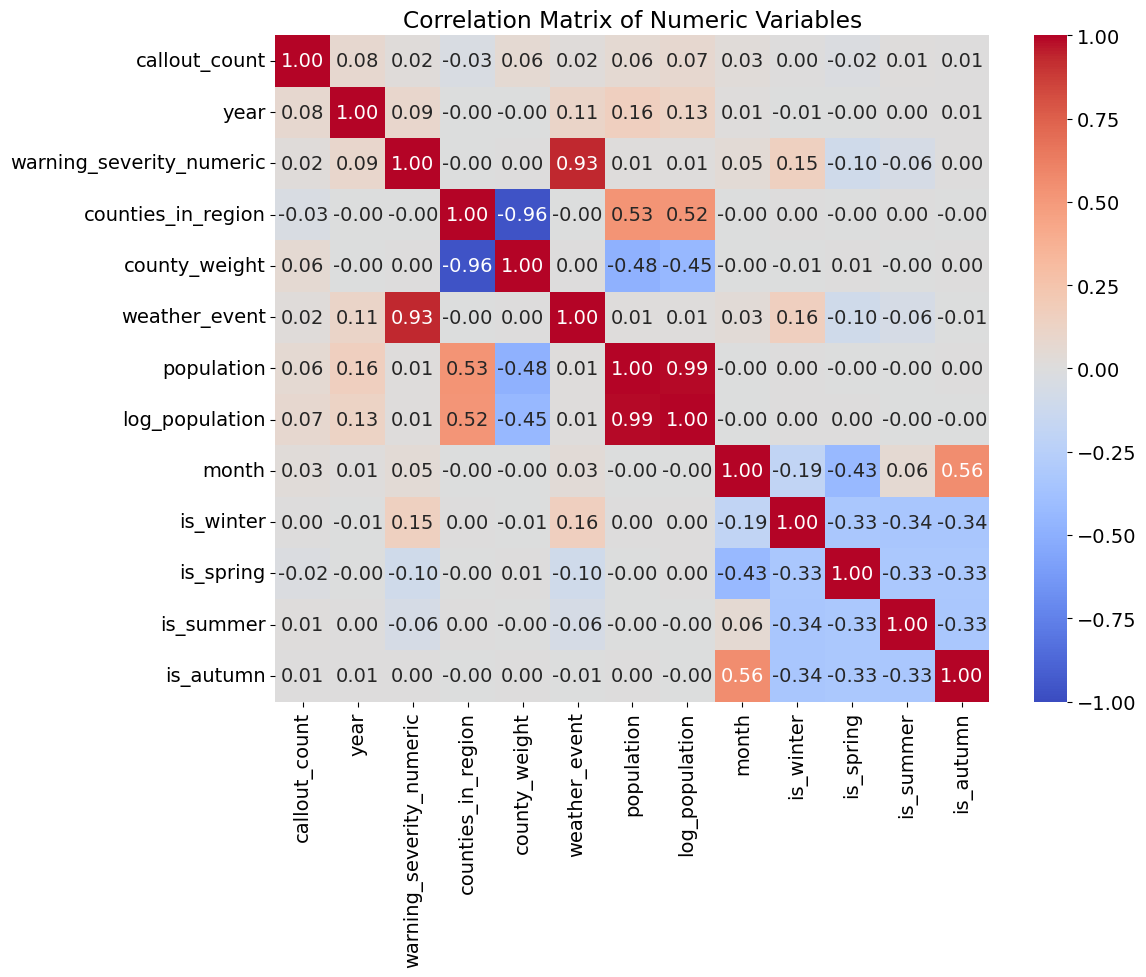

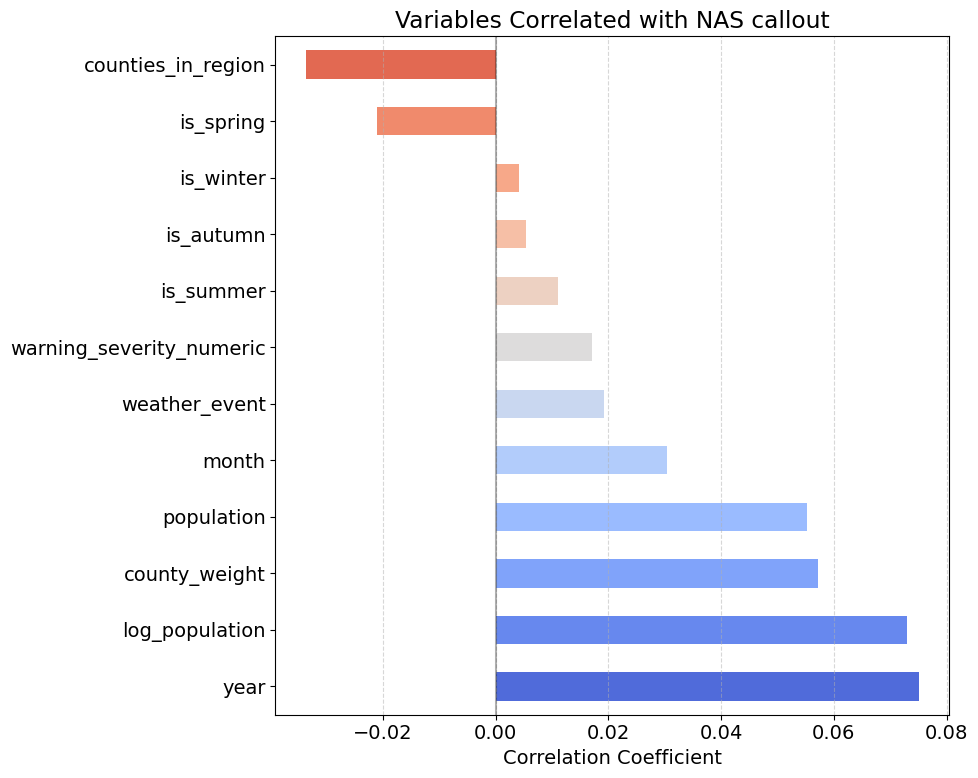

<Figure size 1500x1000 with 0 Axes>

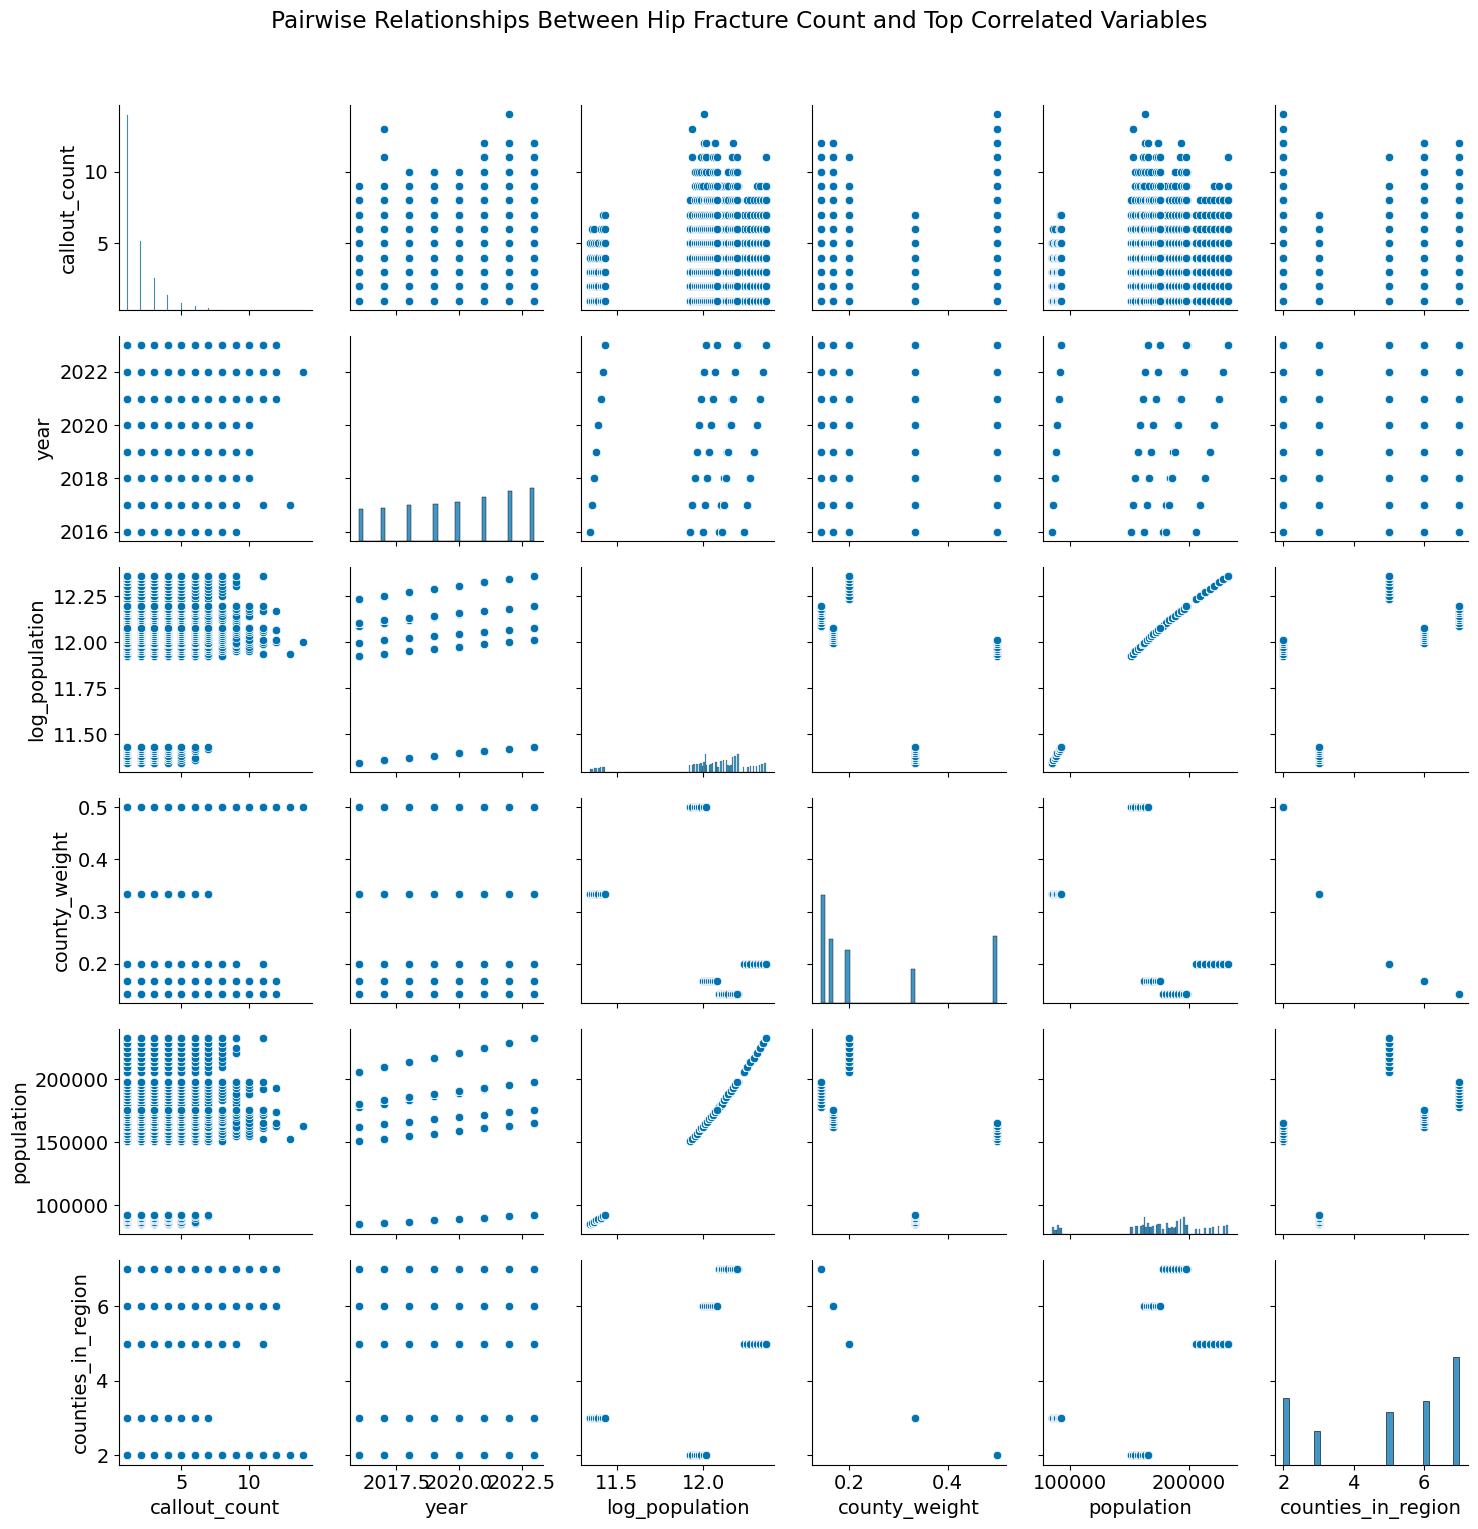

In [59]:
import matplotlib.pyplot as plt
numeric_cols = df_with_pop.select_dtypes(include=[np.number]).columns.tolist()

if 'callout_count' not in numeric_cols:
    print("Warning: callout_count not found in numeric columns")
else:
    # Create a correlation matrix
    corr_matrix = df_with_pop[numeric_cols].corr(method='pearson')
    
    # Sort correlations with hip_fracture_count
    hip_correlations = corr_matrix['callout_count'].sort_values(ascending=False)
    print("Correlations with NAS callout:")
    print(hip_correlations)
    
    # Plot heatmap of correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.show()
    
    # Create a bar plot of correlations with hip_fracture_callout
    plt.figure(figsize=(10, 8))
    hip_correlations.drop('callout_count').plot(kind='barh', color=sns.color_palette("coolwarm", len(hip_correlations)))
    plt.title('Variables Correlated with NAS callout')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # Optional: Create pairplots for top correlated variables
    top_correlated = hip_correlations.drop('callout_count').abs().nlargest(5).index.tolist()
    top_vars = ['callout_count'] + top_correlated
    
    plt.figure(figsize=(15, 10))
    sns.pairplot(df_with_pop[top_vars], height=2.5)
    plt.suptitle('Pairwise Relationships Between Hip Fracture Count and Top Correlated Variables', y=1.02)
    plt.tight_layout()
    plt.show()

In [60]:
df_with_pop.head()

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event,population,log_population,month,season,is_winter,is_spring,is_summer,is_autumn
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
4,HSE Dublin and Midlands,2016-01-01,17D05_chest_neck_injury,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0


In [61]:
## naroow done fall categories 
# Define the categories to keep (high a,d moderate frequency)
high_moderate_categories = [
'17B01_possibly_dangerous',           
'17A02_not_dangerous_proximal',     
'17B00_bravo_override',              
'17D04_not_alert',                     
'17A03_injuries_excluding_distal',    
'17A04_public_assistance'               
#'30A03_traumatic_non_recent'                     
]

# Filter the dataframe to keep only these categories
df_filtered = df_with_pop[df_with_pop['fall_category_group'].isin(high_moderate_categories)]

# Verify the filtering worked
print(f"Original dataframe size: {len(df_with_pop)}")
print(f"Filtered dataframe size: {len(df_filtered)}")
print(f"Categories removed: {len(df_with_pop) - len(df_filtered)} rows")

# You can also check the remaining categories
print(df_filtered['fall_category_group'].value_counts())

Original dataframe size: 91656
Filtered dataframe size: 63478
Categories removed: 28178 rows
fall_category_group
17B01_possibly_dangerous           15965
17A02_not_dangerous_proximal       12584
17B00_bravo_override               11478
17D04_not_alert                    11367
17A03_injuries_excluding_distal     6334
17A04_public_assistance             5750
Name: count, dtype: int64


In [62]:
### Step 10: MixedLM modeling 

In [63]:
# Extract all unique regions from your dataset
all_regions = df_with_pop['region'].unique().tolist()

# Print the regions to verify
print("HSE Regions included in analysis:")
for region in all_regions:
    print(f"- {region}")

HSE Regions included in analysis:
- HSE Dublin and Midlands
- HSE Dublin and North East
- HSE Dublin and South East
- HSE Mid West
- HSE South West
- HSE West and North West


In [64]:
df_filtered.head()

,region,date,fall_category_group,callout_count,year,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event,population,log_population,month,season,is_winter,is_spring,is_summer,is_autumn
0,HSE Dublin and Midlands,2016-01-01,17A02_not_dangerous_proximal,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
1,HSE Dublin and Midlands,2016-01-01,17B00_bravo_override,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
2,HSE Dublin and Midlands,2016-01-01,17B01_possibly_dangerous,3.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
3,HSE Dublin and Midlands,2016-01-01,17D04_not_alert,1.0,2016,Rainfall,Yellow,1.0,7,0.142857,1.0,177614,12.087368,1,Winter,1,0,0,0
7,HSE Dublin and Midlands,2016-01-02,17A03_injuries_excluding_distal,2.0,2016,no_weather_type,no_weather_severity,0.0,7,0.142857,0.0,177614,12.087368,1,Winter,1,0,0,0


In [70]:
import statsmodels
print(f"statsmodels version: {statsmodels.__version__}")

statsmodels version: 0.14.4


In [71]:
df_model.to_csv('/home/paulharford/college/project/project_data/processed/WEATHERED_nas_merged_v2.csv', index=False)

FITTING POISSON MODEL (BASELINE)

Poisson Dispersion parameter: 0.5085

Poisson Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:          callout_count   No. Observations:                63298
Model:                            GLM   Df Residuals:                    63190
Model Family:                 Poisson   Df Model:                          107
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94165.
Date:                Sun, 06 Jul 2025   Deviance:                       32134.
Time:                        16:55:22   Pearson chi2:                 3.52e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2518
Covariance Type:            nonrobust                                         
                                                                                                       coef    std 

/home/paulharford/anaconda3/envs/msc/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:          callout_count   No. Observations:                63298
Model:                            GLM   Df Residuals:                    63190
Model Family:        NegativeBinomial   Df Model:                          107
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1850e+05
Date:                Sun, 06 Jul 2025   Deviance:                       9924.6
Time:                        16:55:32   Pearson chi2:                 1.12e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08900
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------

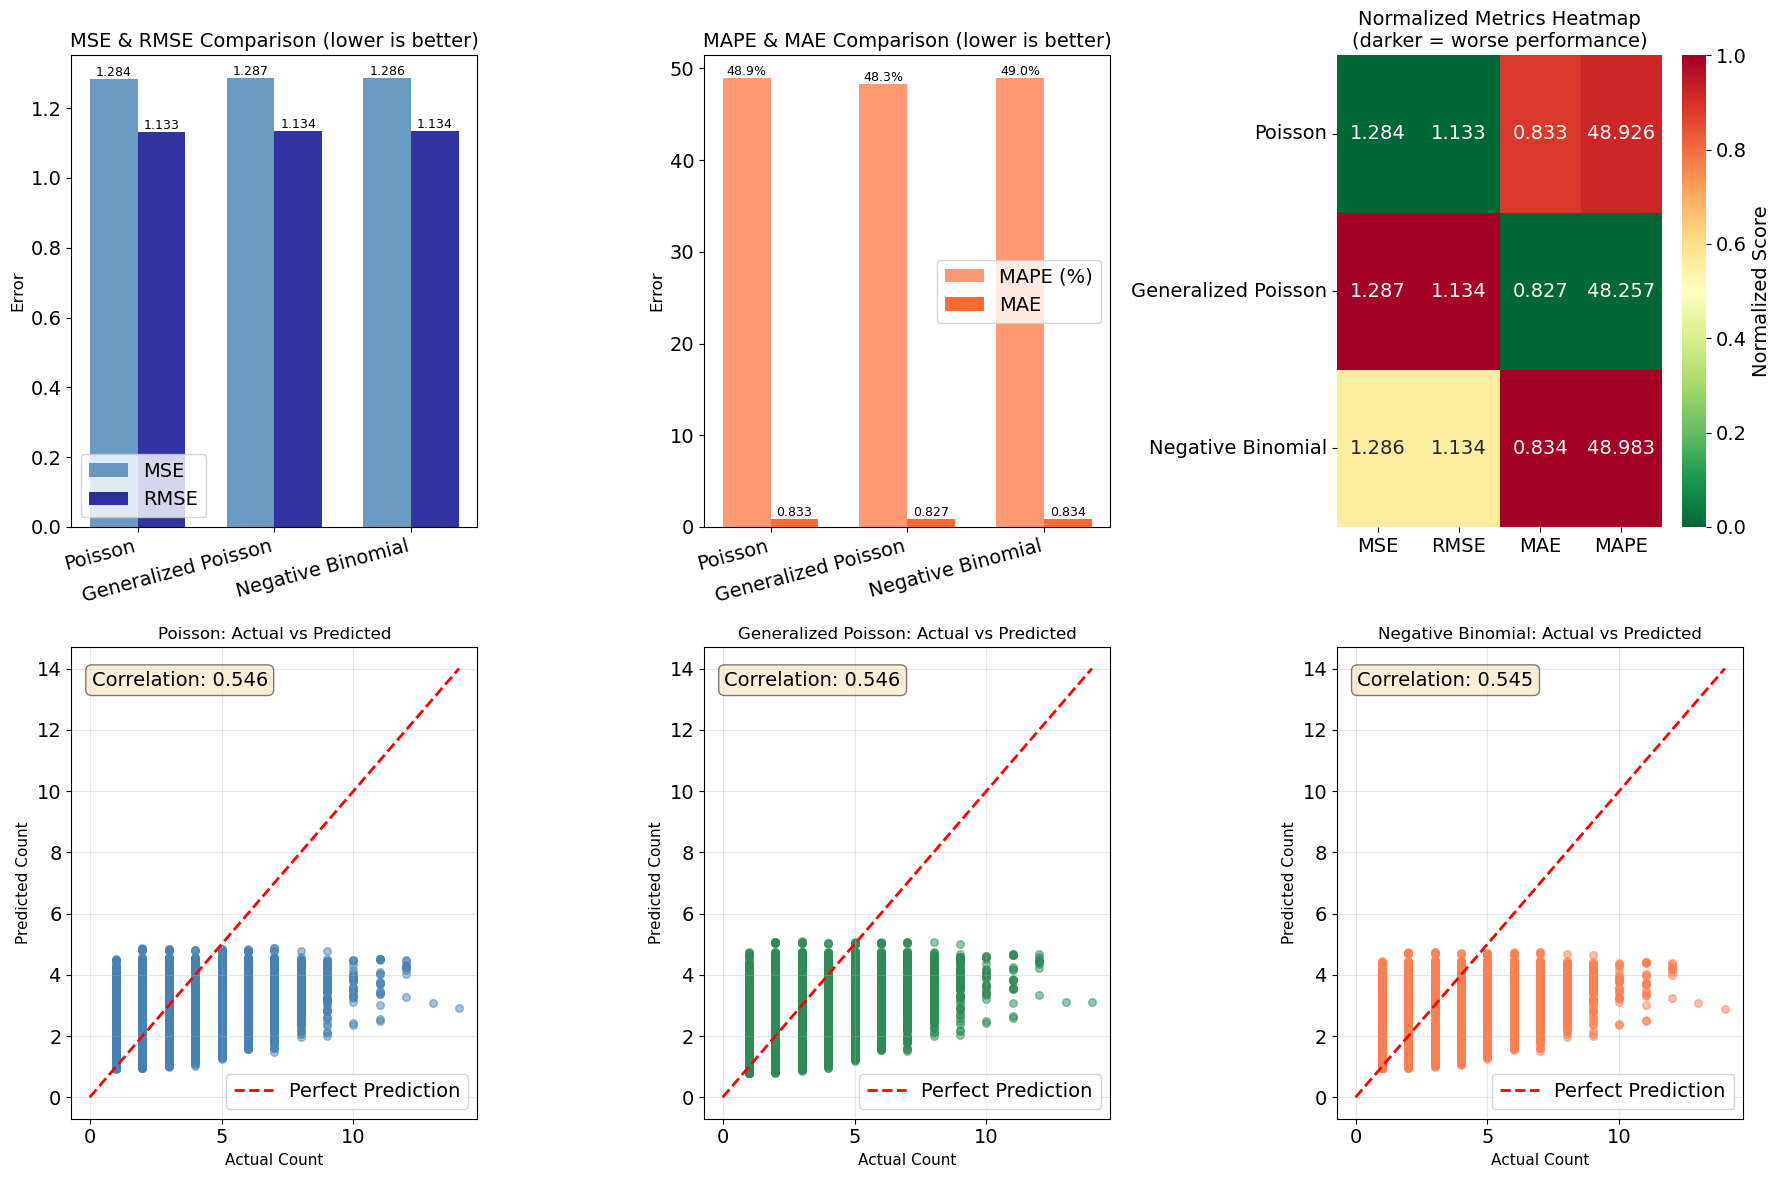

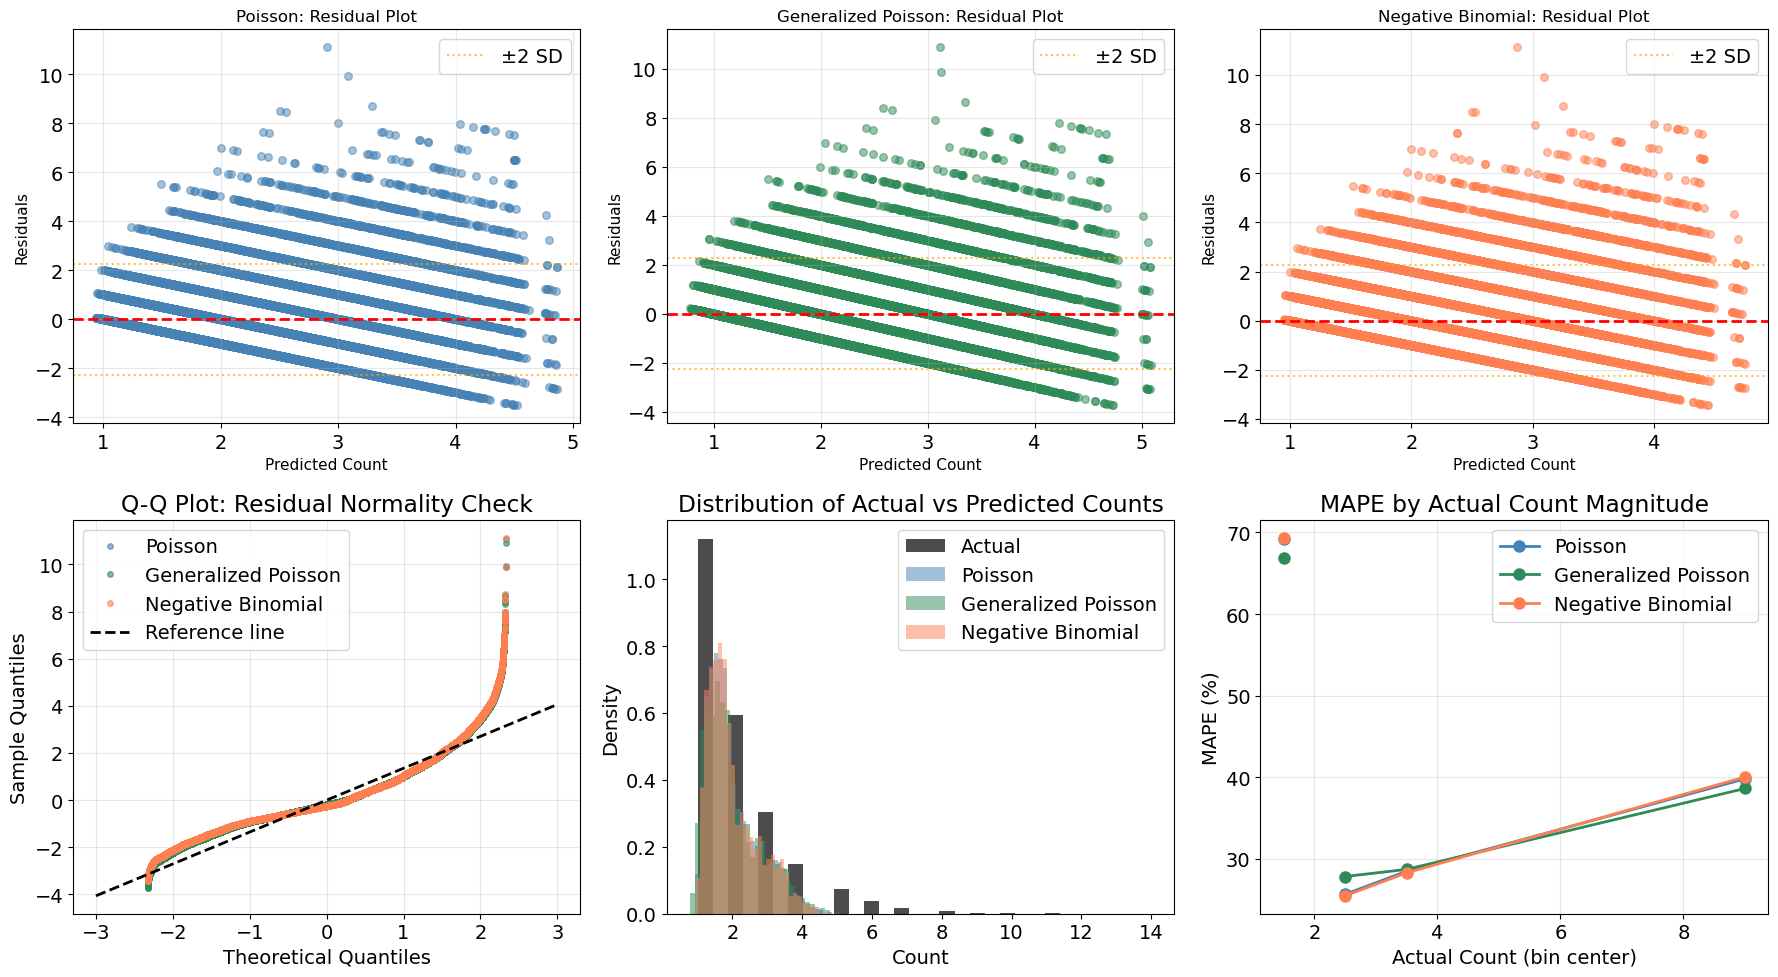


DETAILED MODEL DIAGNOSTICS

Poisson Model:
  Mean Residual: -0.0000
  Std Dev of Residuals: 1.1330
  Min/Max Residual: -3.5203 / 11.0939
  % Predictions within ±1 of actual: 72.2%
  % Predictions within ±2 of actual: 92.4%

Generalized Poisson Model:
  Mean Residual: -0.0000
  Std Dev of Residuals: 1.1345
  Min/Max Residual: -3.7350 / 10.8884
  % Predictions within ±1 of actual: 71.5%
  % Predictions within ±2 of actual: 92.3%

Negative Binomial Model:
  Mean Residual: 0.0013
  Std Dev of Residuals: 1.1338
  Min/Max Residual: -3.4438 / 11.1299
  % Predictions within ±1 of actual: 72.3%
  % Predictions within ±2 of actual: 92.4%

DISPERSION ANALYSIS
Poisson model dispersion parameter: 0.5085
Strong evidence of underdispersion - Generalized Poisson should perform better than standard Poisson

MODEL SELECTION RECOMMENDATION

Based on MSE, the best model is: Poisson
Based on MAPE, the best model is: Generalized Poisson

Generalized Poisson dispersion parameter (alpha): -0.1934
Negative al

/tmp/ipykernel_61618/4005745967.py:391: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gp_alpha = gp_results.params[-1]  # Last parameter is usually dispersion


In [69]:
# Imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import patsy
from statsmodels.discrete.discrete_model import GeneralizedPoisson
import seaborn as sns
from scipy import stats

# Make a copy of your data
df_model = df_filtered.copy()

# Create custom interaction variables for the most significant effects
# 1. Weather-fall category interactions
# 7-day lag (weekly pattern)
df_model['callout_count_lag7'] = df_model.groupby('region')['callout_count'].shift(7)
# 30-day lag (monthly pattern)
df_model['callout_count_lag30'] = df_model.groupby('region')['callout_count'].shift(30)

# Create the design matrices
y, X = patsy.dmatrices(
    "callout_count ~ C(year) + C(month) + C(region) + C(fall_category_group) + "
    "warning_severity:C(fall_category_group) +" 
    "C(region):C(fall_category_group) +"
    "C(year):C(region) +"
    "callout_count_lag30",
    data=df_model,
    return_type='dataframe'
)

# Define the offset - using the indices from y to ensure alignment
offset = df_model.loc[y.index, "log_population"]

# Fit Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
poisson_results = poisson_model.fit()

### 1. Fit Poisson Model (Baseline)
print("="*60)
print("FITTING POISSON MODEL (BASELINE)")
print("="*60)

# Dispersion estimate
dispersion = poisson_results.deviance / poisson_results.df_resid
print(f"\nPoisson Dispersion parameter: {dispersion:.4f}")
print("\nPoisson Model Summary:")
print(poisson_results.summary())

### 2. Fit Generalized Poisson Model (For Underdispersion)
print("\n" + "="*60)
print("FITTING GENERALIZED POISSON MODEL (FOR UNDERDISPERSION)")
print("="*60)

# Convert y to 1D array
y_array = np.asarray(y).flatten()

try:
    gp_model = GeneralizedPoisson(endog=y_array, exog=X, offset=offset)
    gp_results = gp_model.fit(maxiter=1000, disp=False)
    
    print("\nGeneralized Poisson Model Summary:")
    print(gp_results.summary())
    gp_fitted = True
except Exception as e:
    print(f"\nGeneralized Poisson model failed: {e}")
    gp_fitted = False

### 3. Fit Negative Binomial Model (For Comparison)
print("\n" + "="*60)
print("FITTING NEGATIVE BINOMIAL MODEL (FOR COMPARISON)")
print("="*60)

try:
    nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
    nb_results = nb_model.fit(disp=False)
    
    print("\nNegative Binomial Model Summary:")
    print(nb_results.summary())
    nb_fitted = True
except Exception as e:
    print(f"\nNegative Binomial model failed (expected for underdispersed data): {e}")
    nb_fitted = False

### 4. Functions to Calculate MSE and MAPE
def calculate_metrics(y_true, y_pred):
    """
    Calculate MSE and MAPE for model evaluation
    """
    # Ensure arrays are flattened
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    # MSE
    mse = np.mean((y_true - y_pred)**2)
    
    # MAPE - handle zero values
    mask = y_true != 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # MAE
    mae = np.mean(np.abs(y_true - y_pred))
    
    return mse, mape, rmse, mae

### 5. Get predictions and calculate metrics for each model
# IMPORTANT: Get actual values using the same indices as the model
y_actual = df_model.loc[y.index, 'callout_count'].values

# Initialize lists to store results
models_list = []
predictions_list = []
metrics_dict = {}

# Poisson predictions
poisson_pred = poisson_results.predict()
poisson_mse, poisson_mape, poisson_rmse, poisson_mae = calculate_metrics(y_actual, poisson_pred)
models_list.append('Poisson')
predictions_list.append(poisson_pred)
metrics_dict['Poisson'] = (poisson_mse, poisson_mape, poisson_rmse, poisson_mae)

# Generalized Poisson predictions
if gp_fitted:
    gp_pred = gp_results.predict()
    gp_mse, gp_mape, gp_rmse, gp_mae = calculate_metrics(y_actual, gp_pred)
    models_list.append('Generalized Poisson')
    predictions_list.append(gp_pred)
    metrics_dict['Generalized Poisson'] = (gp_mse, gp_mape, gp_rmse, gp_mae)

# Negative Binomial predictions
if nb_fitted:
    nb_pred = nb_results.predict()
    nb_mse, nb_mape, nb_rmse, nb_mae = calculate_metrics(y_actual, nb_pred)
    models_list.append('Negative Binomial')
    predictions_list.append(nb_pred)
    metrics_dict['Negative Binomial'] = (nb_mse, nb_mape, nb_rmse, nb_mae)

# Print comparison
print("\n" + "="*60)
print("MODEL COMPARISON - PREDICTION METRICS")
print("="*60)
for model_name, (mse, mape, rmse, mae) in metrics_dict.items():
    print(f"\n{model_name} Model:")
    print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Check if predictions are different
print("\n" + "="*60)
print("CHECKING PREDICTION DIFFERENCES")
print("="*60)

if len(predictions_list) > 1:
    for i in range(len(predictions_list)-1):
        for j in range(i+1, len(predictions_list)):
            diff = np.mean(np.abs(predictions_list[i] - predictions_list[j]))
            max_diff = np.max(np.abs(predictions_list[i] - predictions_list[j]))
            print(f"\n{models_list[i]} vs {models_list[j]}:")
            print(f"  Mean absolute difference: {diff:.6f}")
            print(f"  Max absolute difference: {max_diff:.6f}")

### 6. Visualization Suite
# Create a figure with multiple subplots
n_models = len(models_list)
fig = plt.figure(figsize=(18, 12))

# Define colors for consistency
colors = ['steelblue', 'seagreen', 'coral'][:n_models]

# 1. Metrics Comparison Bar Plot - MSE and RMSE
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(models_list))
width = 0.35

mse_values = [metrics_dict[m][0] for m in models_list]
rmse_values = [metrics_dict[m][2] for m in models_list]

bars1 = ax1.bar(x - width/2, mse_values, width, label='MSE', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, rmse_values, width, label='RMSE', color='darkblue', alpha=0.8)

ax1.set_ylabel('Error', fontsize=12)
ax1.set_title('MSE & RMSE Comparison (lower is better)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=15, ha='right')
ax1.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. MAPE and MAE Comparison
ax2 = plt.subplot(2, 3, 2)
mape_values = [metrics_dict[m][1] for m in models_list]
mae_values = [metrics_dict[m][3] for m in models_list]

bars3 = ax2.bar(x - width/2, mape_values, width, label='MAPE (%)', color='coral', alpha=0.8)
bars4 = ax2.bar(x + width/2, mae_values, width, label='MAE', color='orangered', alpha=0.8)

ax2.set_ylabel('Error', fontsize=12)
ax2.set_title('MAPE & MAE Comparison (lower is better)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(models_list, rotation=15, ha='right')
ax2.legend()

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Combined Metrics Heatmap
ax3 = plt.subplot(2, 3, 3)
metrics_data = np.array([[metrics_dict[m][0], metrics_dict[m][2], metrics_dict[m][3], metrics_dict[m][1]] 
                         for m in models_list])

# Normalize each metric to 0-1 scale for visualization
metrics_normalized = metrics_data.copy()
for i in range(metrics_data.shape[1]):
    col = metrics_data[:, i]
    if col.max() != col.min():
        metrics_normalized[:, i] = (col - col.min()) / (col.max() - col.min())
    else:
        metrics_normalized[:, i] = 0

sns.heatmap(metrics_normalized, 
            xticklabels=['MSE', 'RMSE', 'MAE', 'MAPE'],
            yticklabels=models_list,
            annot=metrics_data, fmt='.3f', cmap='RdYlGn_r', ax=ax3,
            cbar_kws={'label': 'Normalized Score'})
ax3.set_title('Normalized Metrics Heatmap\n(darker = worse performance)', fontsize=14)

# 4-6. Actual vs Predicted Scatter Plots
for idx, (pred, model_name, color) in enumerate(zip(predictions_list[:3], models_list[:3], colors)):
    ax = plt.subplot(2, 3, 4 + idx)
    ax.scatter(y_actual, pred, alpha=0.5, s=30, color=color)
    
    # Add perfect prediction line
    max_val = max(y_actual.max(), pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Add correlation coefficient
    corr = np.corrcoef(y_actual, pred)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Count', fontsize=11)
    ax.set_ylabel('Predicted Count', fontsize=11)
    ax.set_title(f'{model_name}: Actual vs Predicted', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional diagnostic plots
fig2, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1-3. Residual Plots
for idx, (pred, model_name, color) in enumerate(zip(predictions_list[:3], models_list[:3], colors)):
    if idx < len(axes[0]):
        ax = axes[0, idx]
        residuals = y_actual - pred
        
        ax.scatter(pred, residuals, alpha=0.5, s=30, color=color)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        # Add residual statistics
        res_std = np.std(residuals)
        ax.axhline(y=2*res_std, color='orange', linestyle=':', alpha=0.7, label='±2 SD')
        ax.axhline(y=-2*res_std, color='orange', linestyle=':', alpha=0.7)
        
        ax.set_xlabel('Predicted Count', fontsize=11)
        ax.set_ylabel('Residuals', fontsize=11)
        ax.set_title(f'{model_name}: Residual Plot', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

# 4. Q-Q plot for residuals
ax = axes[1, 0]
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    residuals = y_actual - pred
    stats.probplot(residuals, dist="norm", plot=None)
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))
    theoretical_quantiles.sort()
    residuals_sorted = np.sort(residuals)
    ax.plot(theoretical_quantiles, residuals_sorted, 'o', alpha=0.6, label=model_name, 
            color=color, markersize=4)

ax.plot([-3, 3], [-3*np.std(y_actual), 3*np.std(y_actual)], 'k--', lw=2, label='Reference line')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
ax.set_title('Q-Q Plot: Residual Normality Check')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Distribution of predictions
ax = axes[1, 1]
ax.hist(y_actual, bins=30, alpha=0.7, label='Actual', color='black', density=True)
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    ax.hist(pred, bins=30, alpha=0.5, label=model_name, color=color, density=True)
ax.set_xlabel('Count')
ax.set_ylabel('Density')
ax.set_title('Distribution of Actual vs Predicted Counts')
ax.legend()

# 6. Model performance by prediction magnitude
ax = axes[1, 2]
n_bins = 10
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    # Create bins based on actual values
    bin_edges = np.percentile(y_actual[y_actual > 0], np.linspace(0, 100, n_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    mape_by_bin = []
    for i in range(n_bins):
        mask = (y_actual >= bin_edges[i]) & (y_actual < bin_edges[i+1]) & (y_actual > 0)
        if np.sum(mask) > 0:
            bin_mape = np.mean(np.abs((y_actual[mask] - pred[mask]) / y_actual[mask])) * 100
            mape_by_bin.append(bin_mape)
        else:
            mape_by_bin.append(np.nan)
    
    ax.plot(bin_centers, mape_by_bin, 'o-', label=model_name, color=color, 
            linewidth=2, markersize=8)

ax.set_xlabel('Actual Count (bin center)')
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE by Actual Count Magnitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*60)
print("DETAILED MODEL DIAGNOSTICS")
print("="*60)

for pred, model_name in zip(predictions_list, models_list):
    residuals = y_actual - pred
    print(f"\n{model_name} Model:")
    print(f"  Mean Residual: {np.mean(residuals):.4f}")
    print(f"  Std Dev of Residuals: {np.std(residuals):.4f}")
    print(f"  Min/Max Residual: {np.min(residuals):.4f} / {np.max(residuals):.4f}")
    print(f"  % Predictions within ±1 of actual: {np.mean(np.abs(residuals) <= 1)*100:.1f}%")
    print(f"  % Predictions within ±2 of actual: {np.mean(np.abs(residuals) <= 2)*100:.1f}%")
    
# Dispersion analysis
print("\n" + "="*60)
print("DISPERSION ANALYSIS")
print("="*60)
print(f"Poisson model dispersion parameter: {dispersion:.4f}")

if dispersion < 0.8:
    print("Strong evidence of underdispersion - Generalized Poisson should perform better than standard Poisson")
elif dispersion < 1.0:
    print("Moderate underdispersion detected - Generalized Poisson may improve model fit")
elif dispersion > 1.2:
    print("Overdispersion detected - Negative Binomial might be appropriate")
else:
    print("Little evidence of over/underdispersion - Poisson model may be adequate")

# Model selection recommendation
print("\n" + "="*60)
print("MODEL SELECTION RECOMMENDATION")
print("="*60)

best_model = min(metrics_dict.items(), key=lambda x: x[1][0])[0]  # Based on MSE
print(f"\nBased on MSE, the best model is: {best_model}")

best_model_mape = min(metrics_dict.items(), key=lambda x: x[1][1])[0]  # Based on MAPE
print(f"Based on MAPE, the best model is: {best_model_mape}")

if gp_fitted:
    # Extract dispersion parameter from Generalized Poisson
    try:
        gp_alpha = gp_results.params[-1]  # Last parameter is usually dispersion
        print(f"\nGeneralized Poisson dispersion parameter (alpha): {gp_alpha:.4f}")
        if gp_alpha < 0:
            print("Negative alpha confirms underdispersion in the data")
        elif gp_alpha > 0:
            print("Positive alpha indicates overdispersion")
        else:
            print("Alpha ≈ 0 indicates equidispersion (similar to Poisson)")
    except:
        pass



/tmp/ipykernel_61618/1101057443.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'coef': coefficients[i],
/tmp/ipykernel_61618/1101057443.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'std_err': std_errors[i],
/tmp/ipykernel_61618/1101057443.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'z': z_values[i],
/tmp/ipykernel_61618/1101057443.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

Extracted 109 coefficients:
  Intercept: -11.8050
  C(year)[T.2017]: 0.0965
  C(year)[T.2018]: 0.1095
  C(year)[T.2019]: 0.1442
  C(year)[T.2020]: 0.1358
  ... and 104 more


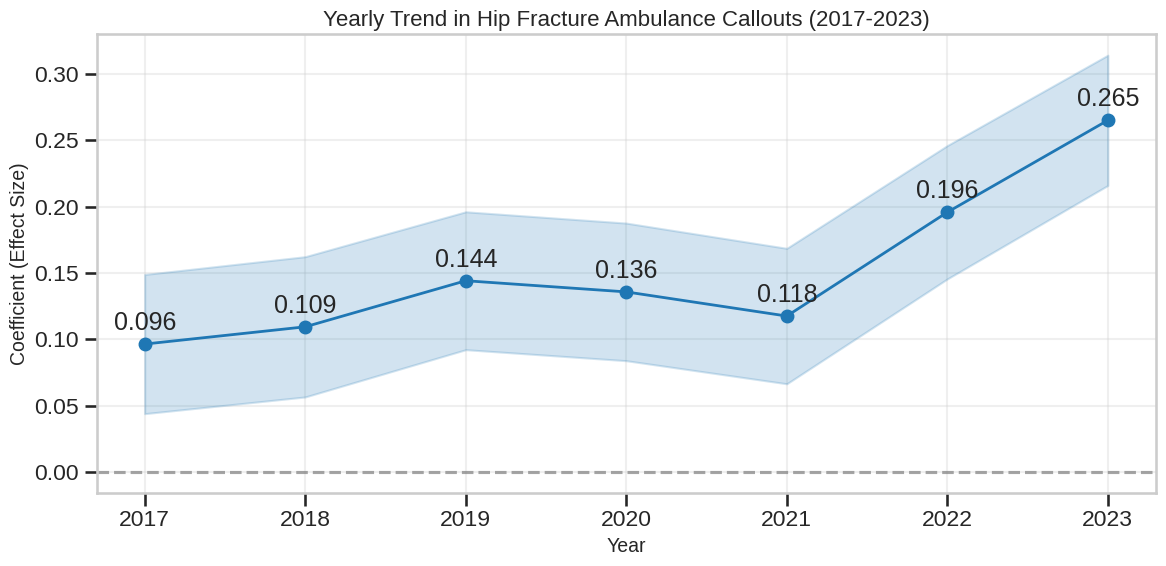

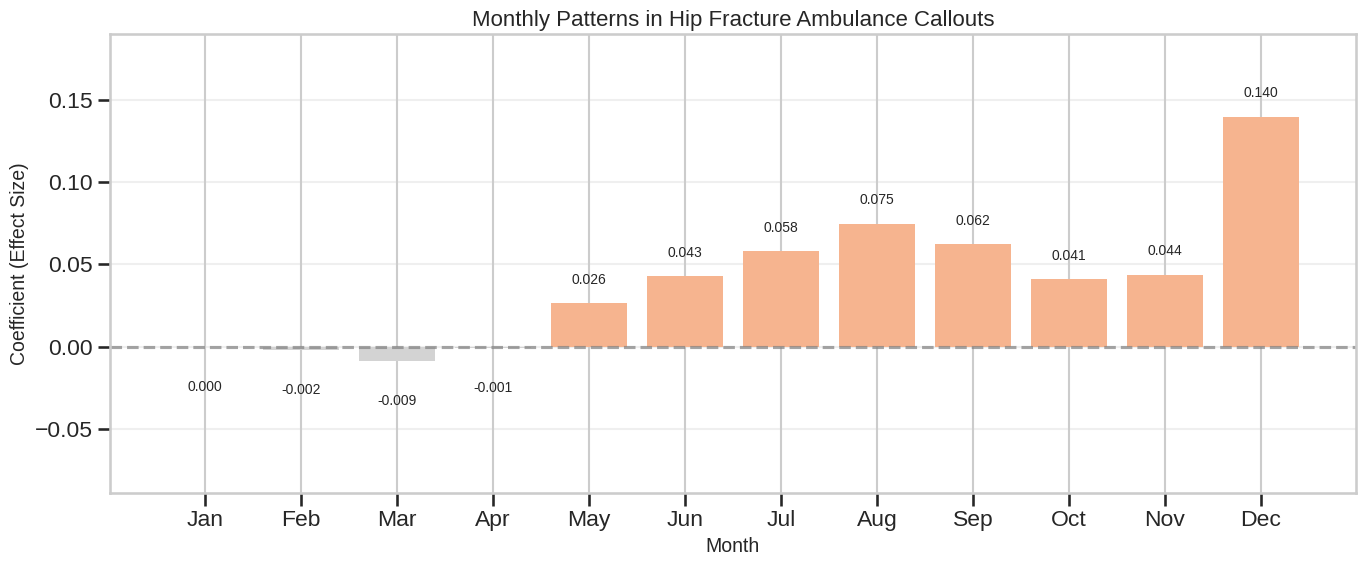

Found 0 weather interaction coefficients out of 7


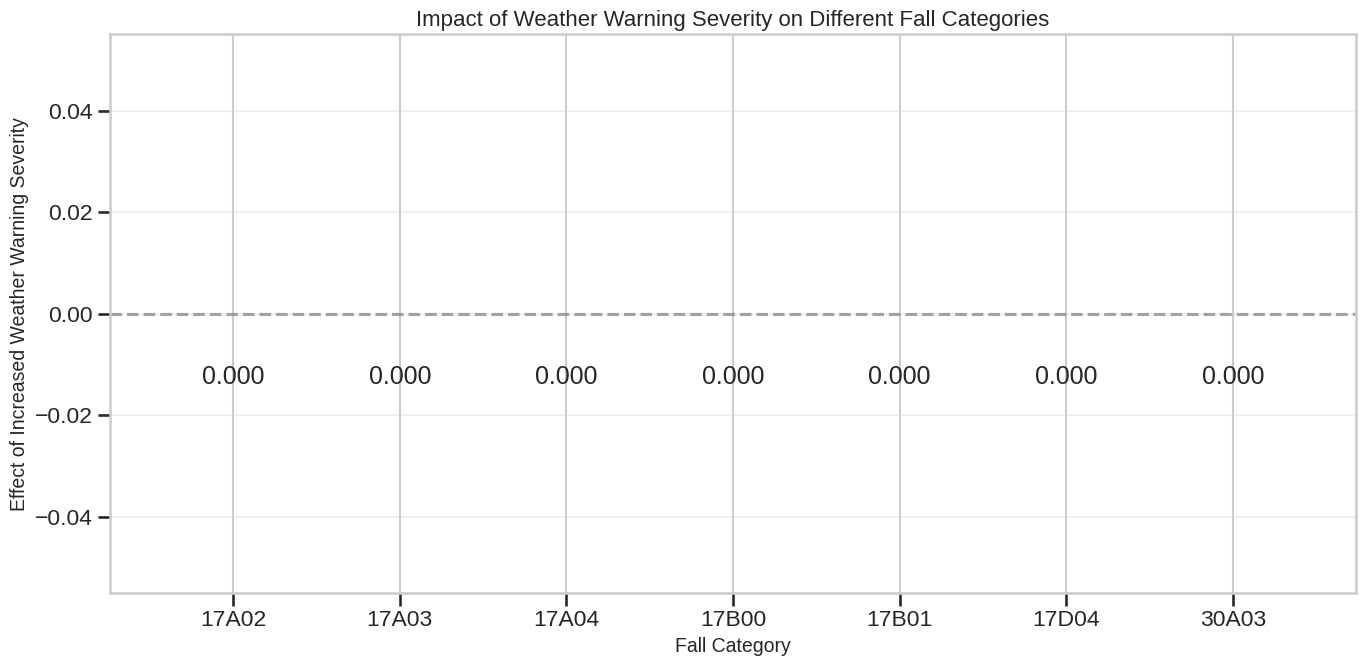

No seasonal weather interaction coefficients found in the model


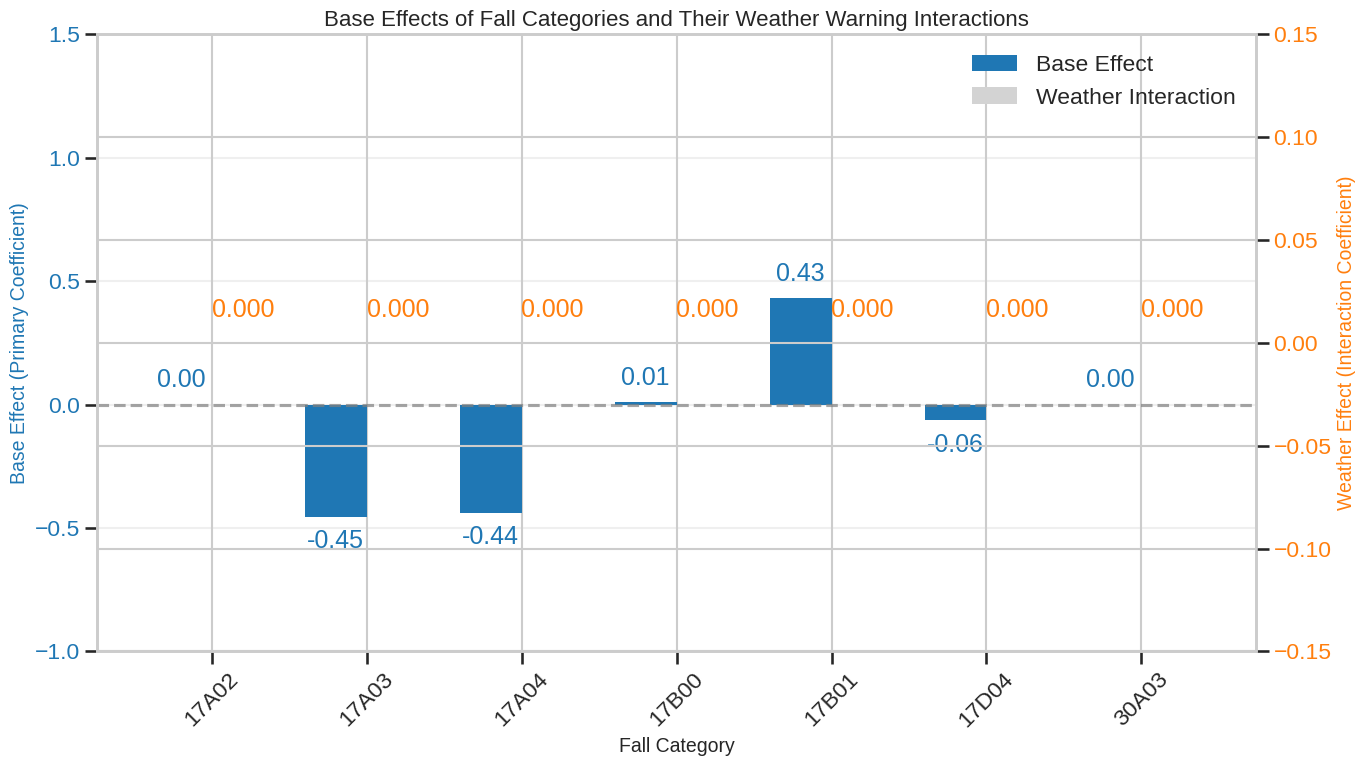

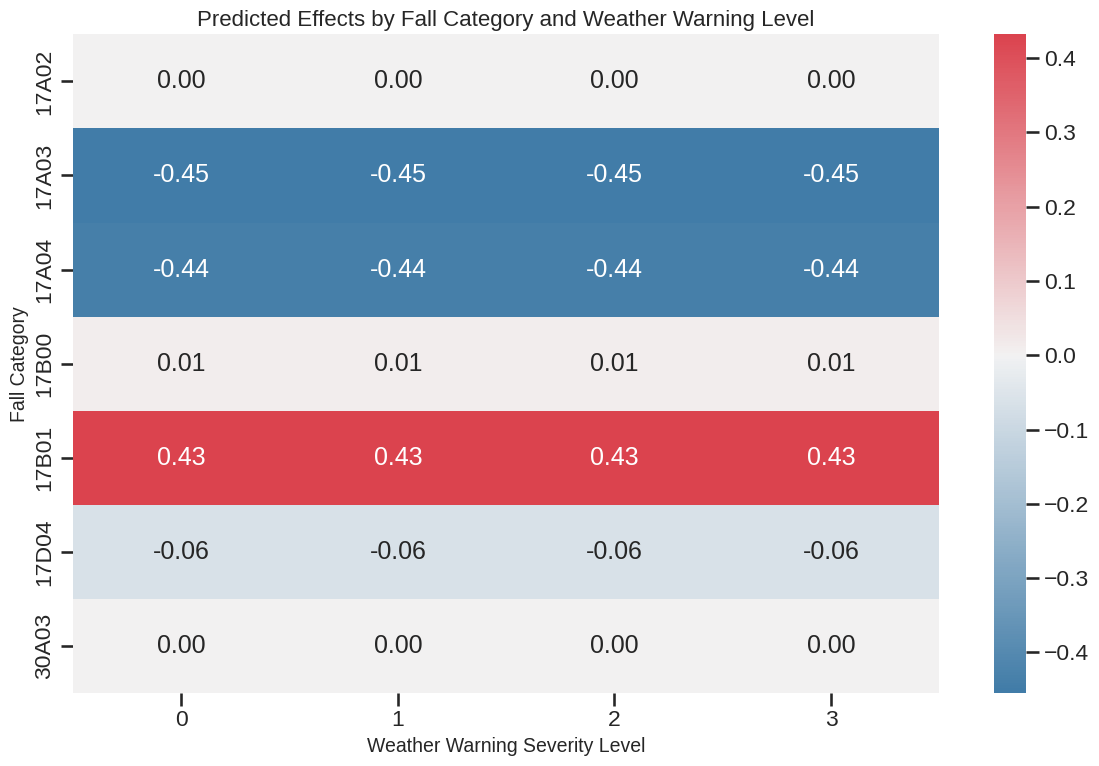

All visualizations have been created successfully.

--- Debug: Available interaction coefficients ---
  warning_severity[T.Red]:C(fall_category_group)[17A02_not_dangerous_proximal]: -0.1879
  warning_severity[T.Yellow]:C(fall_category_group)[17A02_not_dangerous_proximal]: -0.0279
  warning_severity[T.no_weather_severity]:C(fall_category_group)[17A02_not_dangerous_proximal]: 0.0139
  warning_severity[T.Red]:C(fall_category_group)[17A03_injuries_excluding_distal]: 0.0301
  warning_severity[T.Yellow]:C(fall_category_group)[17A03_injuries_excluding_distal]: 0.0280
  warning_severity[T.no_weather_severity]:C(fall_category_group)[17A03_injuries_excluding_distal]: 0.0193
  warning_severity[T.Red]:C(fall_category_group)[17A04_public_assistance]: 0.1951
  warning_severity[T.Yellow]:C(fall_category_group)[17A04_public_assistance]: 0.0533
  warning_severity[T.no_weather_severity]:C(fall_category_group)[17A04_public_assistance]: 0.0644
  warning_severity[T.Red]:C(fall_category_group)[17B00_bravo_o

In [75]:
def extract_coefficients_direct(gp_results):
    """Extract coefficients directly from GeneralizedPoisson results object"""
    coef_data = {}
    
    # Get parameter names
    param_names = gp_results.model.exog_names
    
    # Extract coefficient data
    coefficients = gp_results.params
    std_errors = gp_results.bse
    z_values = gp_results.tvalues
    p_values = gp_results.pvalues
    conf_int = gp_results.conf_int()
    
    # Build the coefficient dictionary
    for i, name in enumerate(param_names):
        coef_data[name] = {
            'coef': coefficients[i],
            'std_err': std_errors[i],
            'z': z_values[i],
            'p_value': p_values[i],
            'ci_lower': conf_int.iloc[i, 0],  # Changed from conf_int[i, 0]
            'ci_upper': conf_int.iloc[i, 1]   # Changed from conf_int[i, 1]
        }
    
    # Also extract the dispersion parameter if available
    if hasattr(gp_results, 'alpha'):
        coef_data['alpha (dispersion)'] = {
            'coef': gp_results.alpha,
            'std_err': None,
            'z': None,
            'p_value': None,
            'ci_lower': None,
            'ci_upper': None
        }
    
    print(f"Extracted {len(coef_data)} coefficients:")
    for i, (key, value) in enumerate(list(coef_data.items())[:5]):
        print(f"  {key}: {value['coef']:.4f}")
    if len(coef_data) > 5:
        print(f"  ... and {len(coef_data) - 5} more")
    
    return coef_data


# Extract coefficients from the model summary
coefficients = extract_coefficients_direct(gp_results)

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")


# 1. Year effects visualization
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
year_coefs = [coefficients[f'C(year)[T.{year}]']['coef'] for year in years]
year_ci_lower = [coefficients[f'C(year)[T.{year}]']['ci_lower'] for year in years]
year_ci_upper = [coefficients[f'C(year)[T.{year}]']['ci_upper'] for year in years]

years_df = pd.DataFrame({
    'Year': years,
    'Coefficient': year_coefs,
    'Lower_CI': year_ci_lower,
    'Upper_CI': year_ci_upper
})

plt.figure(figsize=(12, 6))
plt.plot(years_df['Year'], years_df['Coefficient'], marker='o', linewidth=2, color='#1f77b4')
plt.fill_between(years_df['Year'], years_df['Lower_CI'], years_df['Upper_CI'], alpha=0.2, color='#1f77b4')
plt.title('Yearly Trend in Hip Fracture Ambulance Callouts (2017-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Coefficient (Effect Size)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(years)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
for i, year in enumerate(years):
    plt.annotate(f"{year_coefs[i]:.3f}", (year, year_coefs[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.tight_layout()
plt.savefig('/home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather/yearly_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Month effects visualization
months = list(range(1, 13))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# January is the reference category (coef = 0)
month_coefs = [0.0]  
month_p = [1.0]  # Reference category p-value set to 1

# Add coefficients for months 2-12
for i in range(2, 13):
    key = f'C(month)[T.{i}]'
    if key in coefficients:
        month_coefs.append(coefficients[key]['coef'])
        month_p.append(coefficients[key]['p_value'])

months_df = pd.DataFrame({
    'Month': month_names,
    'Coefficient': month_coefs,
    'Significant': [p < 0.05 for p in month_p]
})

plt.figure(figsize=(14, 6))
bars = plt.bar(months_df['Month'], months_df['Coefficient'], 
       color=[sns.color_palette("rocket_r")[0] if sig else 'lightgray' for sig in months_df['Significant']])
plt.title('Monthly Patterns in Hip Fracture Ambulance Callouts', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Coefficient (Effect Size)', fontsize=14)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.grid(True, axis='y', alpha=0.3)

# Add coefficient values above each bar
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2., height - 0.02,
                f'{height:.3f}', ha='center', va='top')

plt.tight_layout()
plt.savefig('monthly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Extract fall categories base effects
